In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lendingclub import config
from lendingclub.modeling import portfolio_simulating as ps
import seaborn as sns

pd.set_option('max_columns', 999)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

ppath = config.prj_dir
dpath = config.data_dir

In [3]:
all_scores = pd.read_feather(os.path.join(config.data_dir, 'eval_loan_info_scored.fth'))
base_loan_info = pd.read_feather(os.path.join(config.data_dir, 'base_loan_info.fth'))
with open(os.path.join(config.data_dir, 'train_test_ids.pkl'), 'rb') as f:
    train_test_ids = pickle.load(f)
print(all_scores.shape, base_loan_info.shape)

# TURN INT_RATE TO DECIMAL AND ROUND AT 4TH
all_scores['int_rate'] = all_scores['int_rate']/100
all_scores['int_rate'] = all_scores['int_rate'].round(4)

(2507335, 48) (2507335, 90)


# USE TEST IDS TO GENERATE DISTRIBUTIONS OF END_M

In [4]:
# examine the distribution of high maturity time loans for which months they default and prepay
test_id = train_test_ids['test'] # <- test ids
ddone_loans = all_scores.query('id in @test_id and maturity_time >= .95 and loan_status in ["defaulted", "charged_off", "paid"]')
ddone_loans['months_recorded'] = ((ddone_loans['end_d'] - ddone_loans['issue_d'])/np.timedelta64(1, 'M')).round()
ddone_loans['pct_term'] = ddone_loans['months_recorded']/ddone_loans['term']
def_statuses = ['charged_off', 'defaulted']
def_loans = ddone_loans.query('loan_status in @def_statuses')
paid_loans = ddone_loans.query('loan_status not in @def_statuses')

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


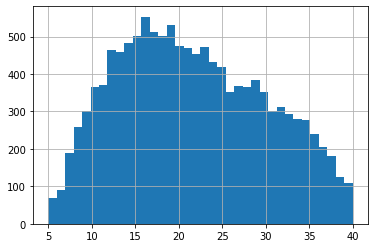

In [5]:
# check how long loans pay for if defaulting or paying for 36 term loans
query = 'term == 36 and months_recorded <= 40 and maturity_time >= .95'
def_probs = (def_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(def_loans.query(query))).to_dict()
def_m, def_prob = zip(*def_probs.items())
ddef_loans = def_loans.query(query)
ddef_loans['months_recorded'].hist(bins=36)

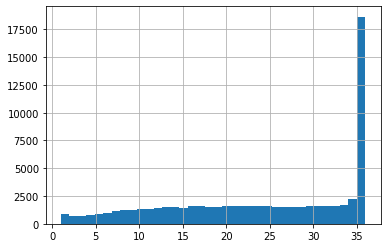

In [6]:
query = 'term == 36 and months_recorded <= 36 and months_recorded >= 1 and maturity_time >= .95'
paid_probs = (paid_loans.query(query)['months_recorded'].value_counts(dropna=False)/len(paid_loans.query(query))).to_dict()
paid_m, paid_prob = zip(*paid_probs.items())
dpaid_loans = paid_loans.query(query)
dpaid_loans['months_recorded'].hist(bins=36)

# is there any correlation between the int_rate/grade of a defaulting/paying loan and when its end_m is? Do loans of different int_rate have different distributions?

In [7]:
term_grade_df = ddone_loans.set_index(['term','grade'])
def_term_grade_df = term_grade_df.query('loan_status in ["defaulted", "charged_off"]')
paid_term_grade_df = term_grade_df.query('loan_status not in ["defaulted", "charged_off"]')
print(term_grade_df.shape, def_term_grade_df.shape, paid_term_grade_df.shape)

(98958, 48) (15974, 48) (82984, 48)


In [173]:
def plot_by_group(df, term, group_cols, target_col, size=(6,5), hist_alpha=.25):
    fig, ax = plt.subplots(figsize=size)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='kde', alpha=1, ax=ax, bw_method=.3)
    df.loc[term,:].groupby(group_cols)[target_col].plot(kind='hist', alpha=hist_alpha, density=True, ax=ax)
    ax.legend()
    plt.show()

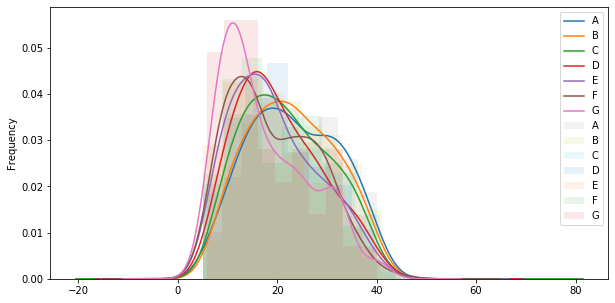

In [174]:
plot_by_group(def_term_grade_df, 36, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

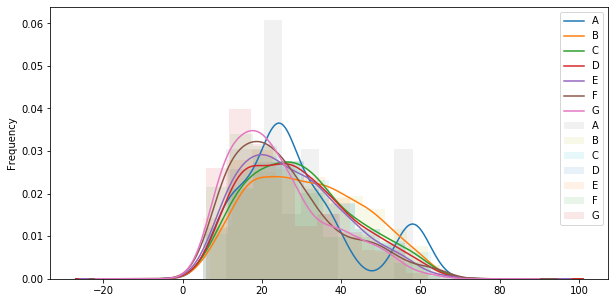

In [175]:
plot_by_group(def_term_grade_df, 60, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

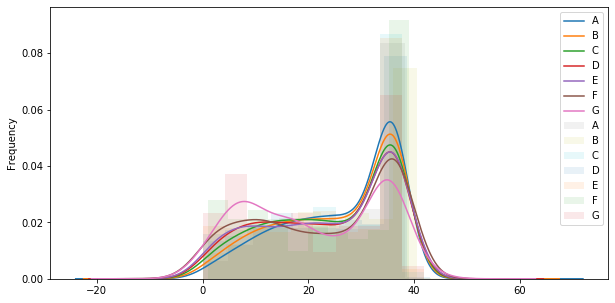

In [176]:
plot_by_group(paid_term_grade_df, 36, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

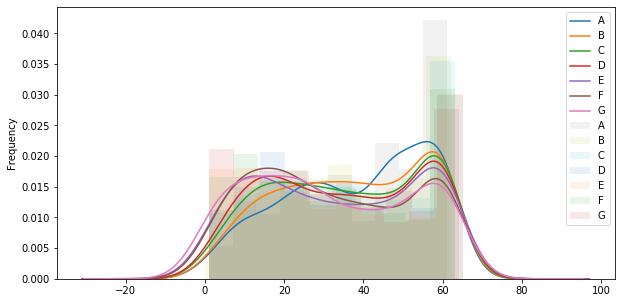

In [177]:
plot_by_group(paid_term_grade_df, 60, 'grade', 'months_recorded', hist_alpha=.1, size=(10,5))

# depending on grade, the distributions of when the loan ends differs. Need to index by term, def/paid, grade

In [13]:
# for purposes here, rename defaulted to charged_off
ddone_loans.loan_status.replace({'defaulted':'charged_off'}, inplace=True)
ddone_loans.loan_status.unique()

/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


array(['paid', 'charged_off'], dtype=object)

In [14]:
end_d_by_term_stat_grade = {}
for term in ddone_loans.term.unique():
    for status in ddone_loans.loan_status.unique():
        for grade in ddone_loans.grade.unique():
            query = 'term == @term and loan_status == @status and grade == @grade'
            loans = ddone_loans.query(query)
            loans = loans.query('months_recorded <= {0}'.format(term + 5))
            ms, probs = zip(*loans.months_recorded.value_counts(normalize=True).to_dict().items())
            end_d_by_term_stat_grade[(term,status,grade)] = (ms, probs)

In [15]:
with open(os.path.join(config.data_dir, 'end_d_by_term_stat_grade.pkl'), 'wb') as f:
    pickle.dump(end_d_by_term_stat_grade, f)

# precompute the ppmt array for use in portfolio simulating

In [160]:
# use rate rounded to 4th decimal
ppmt_by_term_rate = {}
for term in all_scores.term.unique():
    for rate in all_scores.int_rate.unique():
        rate = round(rate,4)
        ppmt_by_term_rate[(term, str(rate))] = np.ppmt(rate/12, np.arange(term)+1, term, -1)

In [161]:
rate = all_scores['int_rate'].sample(1).values[0]
ppmt_by_term_rate[36, str(rate)]

array([0.023, 0.023, 0.023, 0.023, 0.024, 0.024, 0.024, 0.024, 0.025,
       0.025, 0.025, 0.026, 0.026, 0.026, 0.027, 0.027, 0.027, 0.027,
       0.028, 0.028, 0.028, 0.029, 0.029, 0.029, 0.030, 0.030, 0.030,
       0.031, 0.031, 0.031, 0.032, 0.032, 0.033, 0.033, 0.033, 0.034])

In [162]:
with open(os.path.join(config.data_dir, 'ppmt_by_term_rate.pkl'), 'wb') as f:
    pickle.dump(ppmt_by_term_rate, f)

# testing portfolio_simulating module

In [93]:
l_type = 'charged_off' #'paid'
funded = -1
rate = .0999
term = 36
month = 3
cfs = np.array([0.] * 40)
rem_prncp_array = ppmt_by_term_rate[term, str(round(rate,4))]
pmt = np.pmt(rate/12, term, funded)
end_m = 36 # np.random.choice(np.arange(5,41))
ps.make_loan_array(l_type, funded, pmt, month, cfs, rem_prncp_array, end_m = end_m)

array([0.000, 0.000, 0.000, -1.000, 0.032, 0.032, 0.032, 0.032, 0.032,
       0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032,
       0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032,
       0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.000,
       0.000, 0.000, 0.000, 0.000])

In [71]:
np.ppmt(rate/12, np.arange(36)+1, term, -1)[:end_m]

array([0.024, 0.024, 0.024, 0.025, 0.025])

In [90]:
1 - np.ppmt(rate/12, np.arange(36)+1, term, -1)[:end_m].sum() + pmt

0.03226249245484471

In [158]:
ps.sim_portfolio(end_d_by_term_stat_grade, ddone_loans, ppmt_by_term_rate, n_inv_loans=200, funded=funded, ) #wait_for_cont=True, verbose=True

(array([-200.000, 8.303, -0.738, 7.447, 2.199, 7.433, -0.508, 6.685, 2.291,
        8.402, 2.531, 10.582, -2.158, 8.652, 3.156, 10.440, -0.043, 11.643,
        -2.859, 9.564, 0.127, 7.305, 1.573, 7.914, -0.051, 9.252, 0.426,
        9.127, -0.256, 6.922, 1.839, 5.593, 3.343, 6.121, 0.537, 6.367,
        -0.211, 5.634, -1.486, 5.485, -1.555, 3.774, 1.849, 3.073, 0.676,
        3.131, -0.291, 2.832, 2.112, 4.210, 0.163, 3.689, -0.687, 4.018,
        -1.447, 1.868, 1.049, 2.843, -0.307, 2.350, -0.437, 1.525, 0.943,
        1.297, 0.975, 1.274, 0.241, 1.274, 0.756, 1.490, 0.849, 2.097,
        -0.846, 1.053, -0.001, 1.445, 0.558, 1.201, -0.226, 1.696, 0.901,
        0.716, 0.898, -0.157, 0.667, 0.665, 0.158, 0.515, 0.515, -0.520,
        0.676, 0.380, -0.620, 1.033, -0.622, 0.411, 0.543, 0.377, -0.623,
        0.344, 0.344, 0.344, -0.344, 0.311, 0.311, 0.311, 0.311, -0.683,
        0.289, 0.289, 0.289, 0.289, -0.711, 0.924, 0.291, -0.577, 0.647,
        0.231, 0.231, -0.769, 0.266, 0.387, 

# Old writing module below

In [16]:
# Let's model some portfolios

In [17]:
sel_loans = ddone_loans.sample(7)
sel_loans[['loan_status', 'grade', 'term', 'int_rate']]

,loan_status,grade,term,int_rate
1101260,paid,B,36,0.0839
1116657,paid,B,36,0.1149
493620,paid,B,36,0.0867
840234,paid,C,36,0.1367
268185,paid,C,36,0.1464
194520,paid,B,36,0.1099
792521,paid,A,36,0.0789


In [81]:
# %%writefile ../../lendingclub/modeling/portfolio_simulating.py
import numpy as np
from numba import jit

@jit
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
    '''
    it takes 5 months to go from nonpaying to charged_off (90 days late, 120 default, 150 charged off)
    3 l_types:
    A) default immediately, take 5 months
    B) Fully Prepay between 6-12 months. 
    C) Fully Prepay/pay between 24-36 months
    month: what month the loan was invested in (starts at 0 aka 0 indexed)
    end_m is what month the loan willl end relative to month.
    '''
    if theoretic:
        add_m = np.random.choice(np.arange(-3,4))
        if l_type == 'A':
            add_cfs = np.zeros(1)
        else:
            if l_type == 'B':
                n_m = 9+add_m+1
                print(n_m)
            elif l_type == 'C':
                n_m = 33+add_m+1
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (n_m+1))
            rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
            add_cfs[-1] += rem_princp
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs
    else:
        assert end_m is not None, "Pass the months on books/months recorded as end_m"
        # Only 2 l_types 'A' default and 'B' (pre)paid, use end_m
        if l_type == 'charged_off':
            n_m = end_m
            add_cfs = np.array([pmt] * int(n_m - 4))
        elif l_type == 'paid':
            n_m = end_m
            per = np.arange(n_m) + 1
            add_cfs = np.array([pmt] * int(n_m+1))
            rem_princp = round(funded - rem_princp_array[:end_m].sum(), 2)
            add_cfs[-1] += rem_princp
        else:
            print('unrecognized loan type')
        add_cfs[0] = funded
        cfs[month:month+len(add_cfs)] += add_cfs
        return cfs

# @jit
def sim_portfolio(end_d_by_term_stat_grade, sel_loans, ppmt_by_term_rate, n_months=120, n_inv_loans=2000, cfs=None, funded=-1,
                random_state=None, verbose=False, longest_winddown = 76, wait_for_cont=False):
    '''
    Simulate a portfolio for INVESTING for n_months. Actual portfolio winddown
    may take up to 36 months from last investment date
    funded is the loan amount that will be used (e.g. -1 is one dollar funded to loan)
    Args:
        end_d_by_term_stat_grade: dict pickled from 11_portfolio_simulating.ipynb \
        keys are (term, l_stat, grade) and value = tuple(end_m, probability)
        sel_loans: loans that you can possibly invest in. Samples from this for (term,l_stat, grade)
        funded: should be negative
    '''
    # limit it to relevant columns
    sel_loans=sel_loans[['loan_status', 'grade', 'term', 'int_rate']]
    
    cfs=np.zeros(n_months + longest_winddown) if cfs is None else cfs
    end_i = 0
    for month in range(n_months):
        # end_i keeps track of when you have enough money to reinvest
        if month == end_i:
            if verbose:
                print('month is {0} *************************'.format(month))
            # iterate over loans and construct the cfs array
            n_inv_loans = int(np.floor(n_inv_loans))
            starting_money = abs(n_inv_loans*funded)
            loans = sel_loans.sample(n=n_inv_loans, replace=True, random_state=random_state).to_dict('records')
            li_tups = [((l['term'], l['loan_status'], l['grade']), l['int_rate']) for l in loans]
            for l in li_tups:
                # pick the end_m
                key, rate = l
                ms, probs = end_d_by_term_stat_grade[key]
                end_m = np.random.choice(ms, replace=True, p=probs)
                # key is term, stat, grade
                term, stat, grade = key
                pmt = np.pmt(rate/12, term, funded, 0)
                cfs = make_loan_array(stat, funded, pmt, rate/12, term, month, cfs, ppmt_by_term_rate[term, round(rate,5)], theoretic=False, end_m=end_m)
                if verbose:
                    print('picking a loan with term: {0}, status: {1}, grade: {2}, and rate: {3}'.format(*key, rate))
                    print('loan life is {0} ending in month {1}'.format(end_m, end_m+month))
                    if wait_for_cont:
                        pass
#                         import ipdb; ipdb.set_trace()
            if verbose:
                print('invested in {0} loans this month'.format(n_inv_loans))
                print('current cfs: {0}'.format(cfs))
                print('current IRR: {0}'.format(np.irr(cfs)*12))
                print('current unadjusted net money: {0}'.format(np.sum(cfs)))
            # calculate which month can reinvest next in
            leftover_money = starting_money - (n_inv_loans * abs(funded))
            assert leftover_money >= 0, 'somehow negative leftover money'
            end_i = month+1
            while (leftover_money < abs(funded)) and (end_i < len(cfs)):
                leftover_money += cfs[end_i]
                end_i += 1
            n_inv_loans = abs(leftover_money/funded)
    # returns the cfs, the net money made, and the annualized irr
    return cfs, np.sum(cfs), np.irr(cfs)*12

In [82]:
from numba import jit
import numpy as np

In [83]:
# @jit(nopython=True)
# def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
#     '''
#     it takes 5 months to go from nonpaying to charged_off (90 days late, 120 default, 150 charged off)
#     3 l_types:
#     A) default immediately, take 5 months
#     B) Fully Prepay between 6-12 months. 
#     C) Fully Prepay/pay between 24-36 months
#     month: what month the loan was invested in (starts at 0 aka 0 indexed)
#     end_m is what month the loan willl end relative to month.
#     '''
#     assert end_m is not None, "Pass the months on books/months recorded as end_m"
#     # Only 2 l_types 'A' default and 'B' (pre)paid, use end_m
#     if l_type == 'charged_off':
#         n_m = end_m
#         add_cfs = np.array([pmt] * int(n_m - 4))
#     elif l_type == 'paid':
#         n_m = end_m
#         per = np.arange(n_m) + 1
#         add_cfs = np.array([pmt] * int(n_m+1))
#         rem_princp = round(funded - rem_princp_array[:end_m].sum(), 2)
#         add_cfs[-1] += rem_princp
#     else:
#         print('unrecognized loan type')
#     add_cfs[0] = funded
#     cfs[month:month+len(add_cfs)] += add_cfs
#     return cfs

In [84]:
n_months = 30
funded = -1
rate = .0999
term = 36
month = 3
cfs=np.zeros(n_months + 37)
pmt = np.pmt(rate/12, term, funded)
ppmt_by_term_rate[term, round(rate, 5)]
make_loan_array('paid', funded, pmt, rate, term, month, cfs, ppmt_by_term_rate[term, round(rate, 5)], end_m = 10)

<ipython-input-81-6bac02cf9e9d>:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_loan_array" failed type inference due to: Use of unsupported NumPy function 'numpy.tile' or unsupported use of the function.

File "<ipython-input-81-6bac02cf9e9d>", line 27:
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
    <source elided>
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (n_m+1))
            ^

[1] During: typing of get attribute at <ipython-input-81-6bac02cf9e9d> (27)

File "<ipython-input-81-6bac02cf9e9d>", line 27:
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
    <source elided>
            per = np.arange(n_m) + 1
            add_cfs = np.tile(pmt, (n_m+1))
            ^

  @jit
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/numba/object_mode

array([0.000, 0.000, 0.000, -1.000, 0.032, 0.032, 0.032, 0.032, 0.032,
       0.032, 0.032, 0.032, 0.032, -1.018, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
       0.000, 0.000, 0.000, 0.000])

In [85]:
sim_portfolio(end_d_by_term_stat_grade, ddone_loans, ppmt_by_term_rate, n_inv_loans=2, verbose=True, wait_for_cont=False, n_months=120)

<ipython-input-81-6bac02cf9e9d>:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_loan_array" failed type inference due to: Cannot unify array(int64, 1d, C) and array(float64, 1d, C) for '$94.4', defined at <ipython-input-81-6bac02cf9e9d> (26)

File "<ipython-input-81-6bac02cf9e9d>", line 26:
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
    <source elided>
                n_m = 33+add_m+1
            per = np.arange(n_m) + 1
            ^

[1] During: resolving callee type: Function(<built-in function arange>)
[2] During: typing of call at <ipython-input-81-6bac02cf9e9d> (26)


File "<ipython-input-81-6bac02cf9e9d>", line 26:
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
    <source elided>
                n_m = 33+add_m+1
            per = np.arange(n_m) + 1
            ^

  @jit


month is 0 *************************
picking a loan with term: 36, status: charged_off, grade: B, and rate: 0.11140000075101852
loan life is 27.0 ending in month 27.0


/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "make_loan_array" was compiled in object mode without forceobj=True.

File "<ipython-input-81-6bac02cf9e9d>", line 6:
@jit
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
^

  state.func_ir.loc))
/home/justin/anaconda3/envs/lendingclub/lib/python3.7/site-packages/numba/object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-81-6bac02cf9e9d>", line 6:
@jit
def make_loan_array(l_type, funded, pmt, rate, term, month, cfs, rem_princp_array, theoretic = False, end_m = None):
^

  warnings.warn(errors

TypeError: slice indices must be integers or None or have an __index__ method

In [86]:
%debug

> <ipython-input-81-6bac02cf9e9d>(87)sim_portfolio()
     85                 term, stat, grade = key
     86                 pmt = np.pmt(rate/12, term, funded, 0)
---> 87                 cfs = make_loan_array(stat, funded, pmt, rate/12, term, month, cfs, ppmt_by_term_rate[term, round(rate,5)], theoretic=False, end_m=end_m)
     88                 if verbose:
     89                     print('picking a loan with term: {0}, status: {1}, grade: {2}, and rate: {3}'.format(*key, rate))

ipdb> dir()
['cfs', 'end_d_by_term_stat_grade', 'end_i', 'end_m', 'funded', 'grade', 'key', 'l', 'li_tups', 'loans', 'longest_winddown', 'month', 'ms', 'n_inv_loans', 'n_months', 'pmt', 'ppmt_by_term_rate', 'probs', 'random_state', 'rate', 'sel_loans', 'starting_money', 'stat', 'term', 'verbose', 'wait_for_cont']
ipdb> ppmt_by_term_rate[term, round(rate,5)]
array([0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.004,
       0.004, 0.005, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.012,
       0.01

In [103]:
%debug

> <ipython-input-100-5e4c8b91dd5f>(83)sim_portfolio2()
     81                 cfs = make_loan_array(stat, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
     82             # calculate which month can reinvest next in
---> 83             leftover_money = n_inv_loans % (l+1)
     84             end_i = month+1
     85             while leftover_money < abs(funded):

ipdb> l
     78                 # key is term, stat, grade
     79                 term, stat, grade = key
     80                 pmt = np.pmt(rate, term, funded, 0)
     81                 cfs = make_loan_array(stat, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
     82             # calculate which month can reinvest next in
---> 83             leftover_money = n_inv_loans % (l+1)
     84             end_i = month+1
     85             while leftover_money < abs(funded):
     86                 leftover_money += cfs[end_i]
     87                 end_i += 1
     88             n_i

In [74]:
def sim_portfolio(n_months=120, starting_loans=2000, cfs=None, funded=-1,
                  rate = .07/12, term = 36, theoretic = False, def_vs_pay_prob=[.15, .85], ms_prob_tup = None):
    '''
    Simulate a portfolio for INVESTING for n_months. Actual portfolio winddown
    may take up to 36 months longer
    funded is the loan amount that will be used (e.g. -1 is one dollar funded to loan)
    '''

    if not theoretic:
        ms, probs = ms_prob_tup
    
    cfs=np.zeros(n_months + 37) if cfs is None else cfs
    pmt = np.pmt(rate, term, funded, 0)
    end_i = 0
    for month in range(n_months):
        if month == end_i:
            for l in range(int(np.floor(starting_loans))):
                if theoretic:
                    l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, cfs)
                else:
                    l_type = np.random.choice(['charged_off','paid'], replace=True, p=def_vs_pay_prob)
                    if l_type == 'charged_off':
                        end_m = np.random.choice(def_m, replace=True, p=def_prob)
                    elif l_type == 'paid':
                        end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
                    cfs = make_loan_array(l_type, funded, pmt, rate, term, month, cfs, theoretic=False, end_m=end_m)
            # calculate which month can reinvest next in
            leftover_money = starting_loans % (l+1)
            end_i = month+1
            while leftover_money < abs(funded):
                leftover_money += cfs[end_i]
                end_i += 1
            starting_loans = leftover_money
    # returns the cfs, the net money made, and the annualized irr
    return cfs, np.sum(cfs), np.irr(cfs)*12



In [104]:
20 % 13

7

In [9]:
# n_months=120
# month=0
# starting_money = 2000
# # m_start_loans= 10
# cfs = np.zeros(n_months + 37)
# funded = -1
# rate = .07/12
# term = 36
# pmt = np.pmt(rate, term, funded, 0)
# loan_types = ['A','B','C']
# p=[.05,.7,.25]
# end_i = 0
# theoretic = False
# for month in range(n_months):
#     # sample your loan_types
#     if month == end_i:
# #         print('Month {0}'.format(end_i))
#         for l in range(int(np.floor(starting_money))):
#             if theoretic:
#                 l_type = np.random.choice(['A','B','C'], replace=True, p=[.1,.55,.35])
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs)
#             else:
#                 l_type = np.random.choice(['A','B'], replace=True, p=[.15, .85])
#                 if l_type == 'A':
#                     end_m = np.random.choice(def_m, replace=True, p=def_prob)
#                 elif l_type == 'B':
#                     end_m = np.random.choice(paid_m, replace=True, p=paid_prob)
# #                 print(l_type, end_m)
#                 cfs = make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theoretic=False, end_m=end_m)
#         # calculate which month can reinvest next in
# #         print('invest in {0} loans'.format(l+1))
# #         print(cfs)
#         leftover_money = starting_money % (l+1)
# #         print(leftover_money, starting_money)
#         end_i = month+1
#         while leftover_money < abs(funded):
#             leftover_money += cfs[end_i]
#             end_i += 1
#         starting_money = leftover_money
# #         print(starting_money)
# #     import ipdb; ipdb.set_trace()

In [ ]:
#     #2019-11-23 18:19:03 added these probability of def/pay loan ending in which month
#     def_m = (19.0, 20.0, 17.0, 23.0, 13.0, 16.0, 18.0, 15.0, 14.0, 21.0, 22.0, 24.0, 12.0, 25.0, 11.0, 26.0, 27.0, 28.0, 10.0, 30.0, 29.0, 31.0, 9.0, 33.0, 32.0, 34.0, 35.0, 36.0, 8.0, 7.0, 37.0, 38.0, 39.0, 6.0, 40.0, 5.0)
#     def_prob = (0.04215276249174554, 0.04171252476337222, 0.04105216817081224, 0.040721989874532245, 0.03962139555359894, 0.039181157825225625, 0.03896103896103896, 0.0387409200968523, 0.037860444640105656, 0.036429672022892365, 0.03543913713405239, 0.035108958837772396, 0.03499889940567907, 0.033678186220559105, 0.03345806735637244, 0.031587057010785825, 0.030706581554039183, 0.029826106097292537, 0.028285274047985913, 0.02806515518379925, 0.02784503631961259, 0.026194144838212634, 0.02443319392471935, 0.023992956196346026, 0.02201188641866608, 0.02168170812238609, 0.020360994937266123, 0.017609509134932862, 0.017499449702839533, 0.01694915254237288, 0.016178736517719568, 0.014417785604226283, 0.010455646048866387, 0.009134932863746423, 0.009134932863746423, 0.004512436715826546)
#     paid_m = (36.0, 35.0, 34.0, 23.0, 33.0, 29.0, 32.0, 20.0, 19.0, 22.0, 24.0, 25.0, 21.0, 17.0, 28.0, 31.0, 13.0, 14.0, 18.0, 30.0, 27.0, 16.0, 15.0, 26.0, 12.0, 11.0, 8.0, 10.0, 9.0, 7.0, 6.0, 5.0, 1.0, 4.0, 3.0, 2.0)
#     paid_prob = (0.2824742268041237, 0.039646539027982326, 0.025508100147275406, 0.02411389297987236, 0.023524791359842905, 0.02346588119783996, 0.02323024054982818, 0.022876779577810504, 0.022778595974472262, 0.022739322533136964, 0.02268041237113402, 0.022523318605792833, 0.022484045164457536, 0.02242513500245459, 0.02242513500245459, 0.02232695139911635, 0.02228767795778105, 0.021678939617083948, 0.021521845851742757, 0.02150220913107511, 0.02124693176239568, 0.02124693176239568, 0.02059891998036328, 0.020500736377025038, 0.02020618556701031, 0.019695630829651447, 0.01885125184094256, 0.018654884634266077, 0.018046146293568974, 0.01616102110947472, 0.015434462444771722, 0.013294059891998037, 0.012135493372606774, 0.01180166912125675, 0.00997545409916544, 0.009936180657830142)

# To Delete

In [ ]:
# def make_loan_array(l_type, funded, pmt, rate, term, month, n_months, cfs, theortic = False):
#     '''
#     3 l_types:
#     A) default immediately, take 5 months
#     B) Fully Prepay between 6-12 months. 
#     C) Fully Prepay/pay between 24-36 months
#     month: what month the loan was invested in (starts at 0)
#     '''
#     if theoretic:
#         add_m = np.random.choice(np.arange(-3,4))
#         if l_type == 'A':
#             add_cfs = np.zeros(1)
#         else:
#             if l_type == 'B':
#                 n_m = 9+add_m+1
#             elif l_type == 'C':
#                 n_m = 33+add_m+1

        
# # __________________        
#     if l_type == 'A':
#         add_cfs = np.zeros(1)
#     else:
#         if l_type == 'B':
#             n_m = 9+add_m+1
#         elif l_type == 'C':
#             n_m = 33+add_m+1
#         per = np.arange(n_m) + 1
#         add_cfs = np.tile(pmt, (n_m+1))
#         rem_princp = (1 - np.ppmt(rate, per, term, funded, 0).sum()).round(2)
#         add_cfs[-1] += rem_princp
#     add_cfs[0] = funded
#     cfs[month:month+len(add_cfs)] += add_cfs
#     return cfs